### Labrador Embeddings

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder, set_labels_features
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador

### Constants

In [2]:
# Dataset:
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

# Device:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

# Data loader: 
test_size = 0.2
batch_size = 64
num_workers = 4
max_len = 10
MASKING = 0.20

# Model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 12
num_blocks = 12
transformer_feedforward_dim = 3072
dropout_rate = 0.1
continuous_head_activation = 'relu'

# Training:
optimizer = 'Adam'
num_epochs = 15
save_model = True
model_path = 'labrador_model.pth'


### Read dataset

In [3]:
df = pd.read_csv(FILE)
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [4]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

### Generate Sequences

In [5]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [6]:
mrl.head(3)

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc,nstr,lab_ids,lab_values
0,10000032,22595853.0,2180-05-07,0.530612,0.007895,0.258621,0.609524,0.088028,0.585253,0.027731,0.004782,Bic 0.5306122448979591 Crt 0.00789473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.5306122448979591, 0.007894736842105262, 0.2..."
1,10000032,22841357.0,2180-06-27,0.469388,0.007895,0.318966,0.504762,0.102113,0.571429,0.055462,0.007515,Bic 0.46938775510204084 Crt 0.0078947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.007894736842105262, 0...."
2,10000032,25742920.0,2180-08-06,0.489796,0.015789,0.413793,0.504762,0.130282,0.557604,0.053782,0.008539,Bic 0.48979591836734687 Crt 0.0157894736842105...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.48979591836734687, 0.015789473684210523, 0...."


In [7]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.4489795918367347 Crt 0.0289473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000024.0,[Bic 0.46938775510204084 Crt 0.028947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.02894736842105263, 0.3..."
2,20000034.0,[Bic 0.4489795918367347 Crt 0.0605263157894736...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.06052631578947368, 0.28..."


#### Train and Test Split

In [8]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=test_size, random_state=42)

#### Tokenize

In [9]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [10]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10)

{'input_ids': array([[ 7,  0,  1,  3,  5,  4,  2,  6, 10, 10],
        [ 7,  0,  1,  3,  5,  4,  2,  6, 10, 10],
        [ 7,  0,  1,  3,  5,  4,  2,  6, 10, 10],
        [ 7,  0,  1,  3,  5,  4,  2,  6, 10, 10],
        [ 7,  0,  1,  3,  5,  4,  2,  6, 10, 10]]),
 'continuous': array([[6.73469388e-01, 7.89473684e-02, 1.46551724e-01, 6.09523810e-01,
         3.80281690e-01, 6.31336406e-01, 4.15966387e-02, 6.94523511e-03,
         1.00000000e+01, 1.00000000e+01],
        [6.12244898e-01, 2.89473684e-02, 1.37931034e-01, 7.04761905e-01,
         9.85915493e-02, 3.50230415e-01, 7.85714286e-02, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [5.30612245e-01, 2.10526316e-02, 2.06896552e-01, 6.28571429e-01,
         5.63380282e-02, 4.42396313e-01, 1.18067227e-01, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [4.48979592e-01, 1.84210526e-02, 2.32758621e-01, 6.28571429e-01,
         3.16901408e-02, 6.77419355e-01, 1.07983193e-01, 1.04747808e-02,
         1.

### Dataloader

In [11]:
dataset_train = LabradorDataset(continuous=lab_values_train, categorical=lab_ids_train, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Pot': 1, 'Plt': 2, 'Sod': 3, 'Hgb': 4, 'Ure': 5, 'Wbc': 6, 'Bic': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Pot': 1, 'Plt': 2, 'Sod': 3, 'Hgb': 4, 'Ure': 5, 'Wbc': 6, 'Bic': 7}


### Model

In [12]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

In [13]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation=continuous_head_activation, dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=3072, bias=True)
        (1): ReLU()
        (2): Linear(in_features=3072, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): D

### Train the model

In [14]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()  # We'll take the square root of this loss for RMSE

  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|██████████| 827/827 [00:18<00:00, 44.18it/s]


Epoch 1/5, Training Loss: 2.714409710346139, Validation Loss: 2.714047341421697


100%|██████████| 827/827 [00:18<00:00, 44.16it/s]


Epoch 2/5, Training Loss: 2.71342712265981, Validation Loss: 2.7135820155276353


100%|██████████| 827/827 [00:18<00:00, 44.20it/s]


Epoch 3/5, Training Loss: 2.71328961078028, Validation Loss: 2.7143334255541394


100%|██████████| 827/827 [00:18<00:00, 44.17it/s]


Epoch 4/5, Training Loss: 2.7135109137450915, Validation Loss: 2.7126136624683346


100%|██████████| 827/827 [00:18<00:00, 44.12it/s]


Epoch 5/5, Training Loss: 2.713724775787132, Validation Loss: 2.7125895288575808


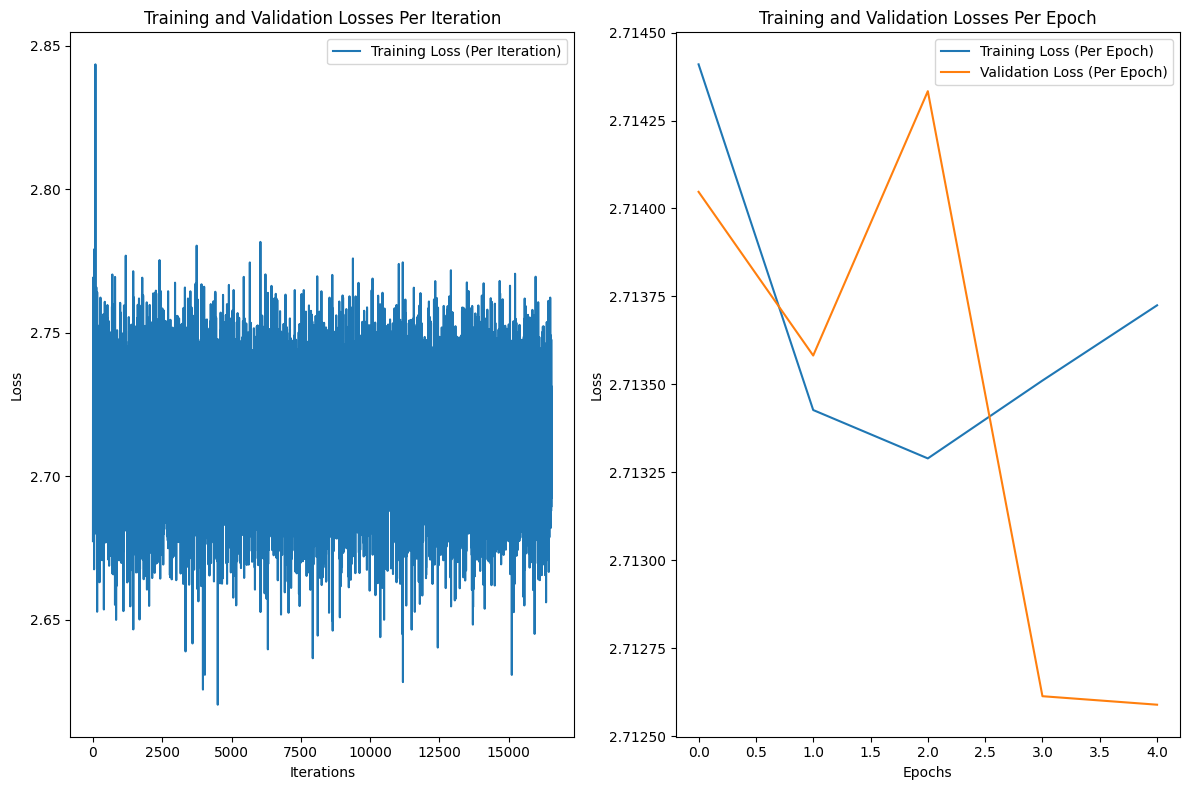

In [15]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=device, save_model=save_model, model_path=model_path)

### Test the model

In [16]:
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=0)
# Dataloader:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Pot': 1, 'Plt': 2, 'Sod': 3, 'Hgb': 4, 'Ure': 5, 'Wbc': 6, 'Bic': 7}


In [59]:
from tqdm import tqdm
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def test_model(model, test_loader, device, labs_list):
    model.to(device)
    model.eval()

    metrics = {lab: {'rmse': [], 'mae': [], 'r2': []} for lab in labs_list}

    with torch.no_grad():
        for lab in labs_list:
            print(f'Evaluating {lab}: ')
            lab_token = test_loader.dataset.tokenizer.vocab[lab]

            preds = []
            true_vals = []
            count = 0

            for batch in tqdm(test_loader, leave=True):
                lab_idx = (batch['input_ids'] == lab_token)
                batch['continuous'][lab_idx] = torch.tensor(test_loader.dataset.tokenizer.mask_token, dtype=torch.float32, device=device)

                input_ids = batch['input_ids'].to(device)
                continuous = batch['continuous'].to(device)
                attn_mask = batch['attention_mask'].to(device)
                labels_continuous = batch['labels_continuous'].to(device)
                
                if count == 0:
                    #print(f'Input ids: {input_ids}')
                    #print(f'Continuous: {continuous}')
                    #print(f'Attn mask: {attn_mask}')
                    #print(f'Labels continuous: {labels_continuous}')
                    pass

                outputs = model(input_ids, continuous, attn_mask=attn_mask)
                continuous_output = outputs['continuous_output'].squeeze(-1)
                if count == 0:
                    #print(f'Continuous output: {continuous_output}')
                    pass

                masked_cont_indices = (continuous == test_loader.dataset.tokenizer.mask_token).to(device)
                batch_preds = continuous_output[masked_cont_indices]
                batch_labels = labels_continuous[masked_cont_indices].to(device)

                preds.extend(batch_preds.tolist())
                true_vals.extend(batch_labels.tolist())
                
                if count == 0:
                    print(f'Preds: {batch_preds.tolist()}')
                    print(f'True vals: {batch_labels.tolist()}')
                    count += 1

            rmse = np.sqrt(mean_squared_error(true_vals, preds))
            mae = mean_absolute_error(true_vals, preds)
            r2 = r2_score(true_vals, preds)

            metrics[lab]['rmse'].append(rmse)
            metrics[lab]['mae'].append(mae)
            metrics[lab]['r2'].append(r2)

            print(f'RMSE: {rmse:.3f}')
            print(f'MAE: {mae:.3f}')
            print(f'R2: {r2:.3f}')
            print('-------------------')

    return metrics


In [60]:
test_model(trained_model, test_loader, device, COLUMNS)

Evaluating Bic: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 5/827 [00:00<00:52, 15.57it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.4285714328289032, 0.5306122303009033, 0.4897959232330322, 0.5102040767669678, 0.5714285969734192, 0.4693877696990967, 0.5102040767669678, 0.3877550959587097, 0.3469387888908386, 0.5102040767669678, 0.5306122303009033, 0.4897959232330322, 0.4285714328289032, 0.4285714328289032, 0.5510203838348389, 0.4285714328289032, 0.5102040767669678, 0.4693877696990967, 0.3877550959587097, 0.6326530575752258, 0.4285714328289032, 0.5510203838348389, 0.5102040767669678, 0.4897959232330322, 0.5918367505073547, 0.40816327929496765, 0.4693877696990967, 0.3469387888908386, 0.5306122303009033, 0.5102040767669678, 0.5306122303009033, 0.5918367505073547, 0.3877550959587097,

100%|██████████| 827/827 [00:18<00:00, 44.50it/s]


RMSE: 0.486
MAE: 0.479
R2: -37.309
-------------------
Evaluating Crt: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:43, 19.05it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.015789473429322243, 0.03421052545309067, 0.02631578966975212, 0.010526316240429878, 0.018421052023768425, 0.031578946858644485, 0.031578946858644485, 0.04210526496171951, 0.09210526198148727, 0.018421052023768425, 0.028947368264198303, 0.05263157933950424, 0.018421052023768425, 0.02368421107530594, 0.03684210404753685, 0.02631578966975212, 0.021052632480859756, 0.02368421107530594, 0.031578946858644485, 0.057894736528396606, 0.021052632480859756, 0.4236842095851898, 0.018421052023768425, 0.021052632480859756, 0.021052632480859756, 0.02631578966975212, 0.02631578966975212, 0.02631578966975212, 0.018421052023768425, 0.02368421107530594, 0.0263157896697

100%|██████████| 827/827 [00:18<00:00, 44.62it/s]


RMSE: 0.053
MAE: 0.035
R2: -0.733
-------------------
Evaluating Pot: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:42, 19.14it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.2586206793785095, 0.18103447556495667, 0.16379310190677643, 0.24137930572032928, 0.27586206793785095, 0.21551723778247833, 0.22413793206214905, 0.18103447556495667, 0.31896552443504333, 0.2068965584039688, 0.17241379618644714, 0.25, 0.23275862634181976, 0.23275862634181976, 0.25, 0.22413793206214905, 0.16379310190677643, 0.2068965584039688, 0.22413793206214905, 0.2068965584039688, 0.18965516984462738, 0.3448275923728943, 0.24137930572032928, 0.2068965584039688, 0.25, 0.22413793206214905, 0.18965516984462738, 0.22413793206214905, 0.23275862634181976, 0.24137930572032928, 0.21551723778247833, 0.23275862634181976, 0.2068965584039688, 0.22413793206214905

100%|██████████| 827/827 [00:18<00:00, 44.66it/s]


RMSE: 0.230
MAE: 0.225
R2: -23.767
-------------------
Evaluating Sod: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:42, 19.25it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.5809524059295654, 0.6380952596664429, 0.6285714507102966, 0.6285714507102966, 0.6190476417541504, 0.6666666865348816, 0.561904788017273, 0.5523809790611267, 0.6285714507102966, 0.6000000238418579, 0.6761904954910278, 0.6285714507102966, 0.6571428775787354, 0.6000000238418579, 0.6952381134033203, 0.561904788017273, 0.6095238327980042, 0.5809524059295654, 0.6857143044471741, 0.6666666865348816, 0.6380952596664429, 0.6000000238418579, 0.6380952596664429, 0.6095238327980042, 0.6190476417541504, 0.6285714507102966, 0.6571428775787354, 0.6761904954910278, 0.6190476417541504, 0.6952381134033203, 0.6476190686225891, 0.5904762148857117, 0.6285714507102966, 0.

100%|██████████| 827/827 [00:18<00:00, 44.61it/s]


RMSE: 0.628
MAE: 0.627
R2: -276.257
-------------------
Evaluating Ure: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:43, 18.89it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.05281690135598183, 0.07042253762483597, 0.035211268812417984, 0.05281690135598183, 0.028169013559818268, 0.0845070406794548, 0.0211267601698637, 0.22535210847854614, 0.25704225897789, 0.04929577559232712, 0.11267605423927307, 0.10915493220090866, 0.056338027119636536, 0.07042253762483597, 0.15492957830429077, 0.0809859186410904, 0.014084506779909134, 0.04929577559232712, 0.06690140813589096, 0.18661971390247345, 0.04929577559232712, 0.27112674713134766, 0.035211268812417984, 0.0422535203397274, 0.03169013932347298, 0.05281690135598183, 0.03873239457607269, 0.04929577559232712, 0.0422535203397274, 0.06338027864694595, 0.07746478915214539, 0.0633802786

100%|██████████| 827/827 [00:18<00:00, 44.44it/s]


RMSE: 0.097
MAE: 0.075
R2: -1.485
-------------------
Evaluating Hgb: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:43, 19.04it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.40092167258262634, 0.599078357219696, 0.4055299460887909, 0.6221198439598083, 0.5622119903564453, 0.6820276379585266, 0.4838709533214569, 0.4700460731983185, 0.4193548262119293, 0.3870967626571655, 0.5115207433700562, 0.5668202638626099, 0.6129032373428345, 0.35944700241088867, 0.299539178609848, 0.40092167258262634, 0.4516128897666931, 0.6313363909721375, 0.4055299460887909, 0.4516128897666931, 0.5622119903564453, 0.35944700241088867, 0.4423963129520416, 0.6543778777122498, 0.6728110313415527, 0.5437787771224976, 0.6820276379585266, 0.460829496383667, 0.4976958632469177, 0.695852518081665, 0.539170503616333, 0.5806451439857483, 0.5253456234931946, 0

100%|██████████| 827/827 [00:18<00:00, 44.60it/s]


RMSE: 0.516
MAE: 0.507
R2: -28.780
-------------------
Evaluating Plt: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:43, 18.90it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.10042016953229904, 0.043697480112314224, 0.05504201725125313, 0.0865546241402626, 0.13445378839969635, 0.1184873953461647, 0.05714285746216774, 0.07689075917005539, 0.09159664064645767, 0.02521008439362049, 0.07731092721223831, 0.0752100870013237, 0.07184874266386032, 0.07563025504350662, 0.21722689270973206, 0.09663865715265274, 0.1239495798945427, 0.07352941483259201, 0.05126050487160683, 0.08781512826681137, 0.12731093168258667, 0.12352941185235977, 0.0865546241402626, 0.10084033757448196, 0.061764705926179886, 0.0920168086886406, 0.08109243959188461, 0.0865546241402626, 0.22310924530029297, 0.08697479218244553, 0.06974790245294571, 0.107983194291

100%|██████████| 827/827 [00:18<00:00, 44.49it/s]


RMSE: 0.104
MAE: 0.093
R2: -4.003
-------------------
Evaluating Wbc: 


  0%|          | 0/827 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
  1%|          | 6/827 [00:00<00:42, 19.19it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True vals: [0.005465102847665548, 0.004668108653277159, 0.009108505211770535, 0.006262097042053938, 0.012068768963217735, 0.010816349647939205, 0.009563930332660675, 0.0034156893379986286, 0.012979620136320591, 0.009450074285268784, 0.006375953555107117, 0.009450074285268784, 0.007856085896492004, 0.012524194084107876, 0.015484458766877651, 0.010702493600547314, 0.006945235189050436, 0.008994649164378643, 0.006148240994662046, 0.010247068479657173, 0.011613343842327595, 0.004212683532387018, 0.007628372870385647, 0.012410338036715984, 0.0064898100681602955, 0.01457360852509737, 0.006603666115552187, 0.007628372870385647, 0.013207332231104374, 0.009563930332660675,

100%|██████████| 827/827 [00:18<00:00, 44.52it/s]

RMSE: 0.012
MAE: 0.010
R2: -1.680
-------------------


{'Bic': {'rmse': [0.48574286881278766],
  'mae': [0.4793611768663539],
  'r2': [-37.309183376881805]},
 'Crt': {'rmse': [0.05315096578868614],
  'mae': [0.03456101898744428],
  'r2': [-0.7325478394361615]},
 'Pot': {'rmse': [0.22957351507957063],
  'mae': [0.22489106396818662],
  'r2': [-23.766821616843746]},
 'Sod': {'rmse': [0.6277011791699629],
  'mae': [0.6265681715770638],
  'r2': [-276.2568333339704]},
 'Ure': {'rmse': [0.09737584863968306],
  'mae': [0.07527863970508245],
  'r2': [-1.4853480506573034]},
 'Hgb': {'rmse': [0.5159875282008837],
  'mae': [0.507250327078953],
  'r2': [-28.78032804847579]},
 'Plt': {'rmse': [0.10435480785320787],
  'mae': [0.09334520014514568],
  'r2': [-4.003183067103118]},
 'Wbc': {'rmse': [0.012445089987730659],
  'mae': [0.00985360168744061],
  'r2': [-1.6802015094659697]}}